<html> <h1 style="font-style:bold; color:blue;"> Neural Computing and Deep Learning </h1> </html>

<html> <h1 style="font-style:italic; color:blue;"> Week-12 </h1> </html>

<html> <h2 style="font-style:italic; color:blue;"> Attention Networks </21> </html>

The tutorial will cover the following:

* Preparing a simple dataset for time series forecasting
* How to use a network built via SimpleRNN for time series forecasting
* Adding a custom attention layer to the SimpleRNN network

In [1]:
from pandas import read_csv
import numpy as np

import tensorflow as tf
from tensorflow import keras

from keras import Model
from tensorflow.keras.layers import Layer
from keras.layers import Input, Dense, SimpleRNN

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.metrics import mean_squared_error

In [2]:
print(tf.__version__)

2.18.0


### The Dataset

We will create a fibonacci sequence dataset for our purpose. In Fibonacci sequence, one number is constructed from the previous two numbers. The first 10 numbers of the sequence are shown below:

0, 1, 1, 2, 3, 5, 8, 13, 21, 34, …


When given the previous ‘t’ numbers, can you get a machine to accurately reconstruct the next number? This would mean discarding all the previous inputs except the last two and performing the correct operation on the last two numbers.

For this tutorial, you’ll construct the training examples from t time steps and use the value at t+1 as the target. For example, if t=3, then the training examples and the corresponding target values would look as follows:


![image.png](attachment:image.png)

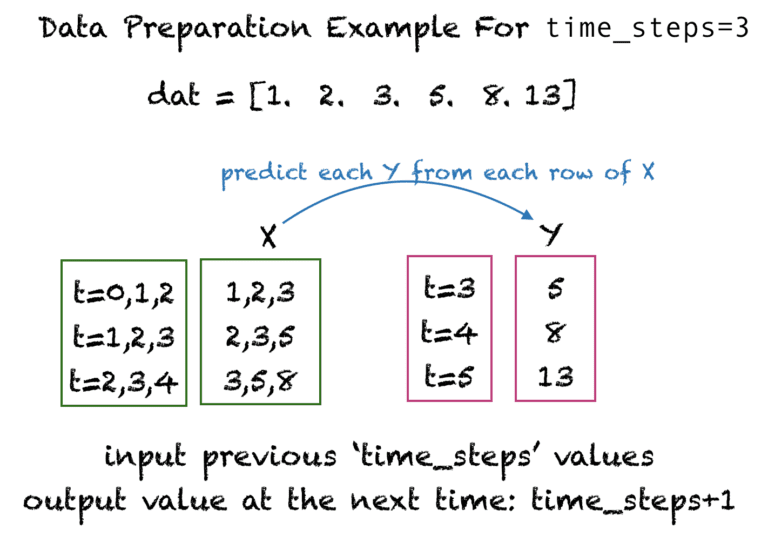

![image.png](attachment:image.png)

The Fibonacci spiral: an approximation of the **golden spiral** created by drawing circular arcs connecting the opposite corners of squares in the Fibonacci tiling

### Data preprocessing

In [3]:
def get_fib_seq(n, scale_data=True):
    # Get the Fibonacci sequence
    seq = np.zeros(n)
    fib_n1 = 0.0
    fib_n = 1.0
    for i in range(n):

            # Create the Fibonacci sequence. Store the sequence in an numpy array 'seq'
            seq[i] = fib_n1 + fib_n
            fib_n1 = fib_n
            fib_n = seq[i]

    scaler = []
    if scale_data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        seq = np.reshape(seq, (n, 1))
        seq = scaler.fit_transform(seq).flatten()
    return seq, scaler

In [4]:
# Check if the function works correctly

In [5]:
def get_fib_seq_check(n, scale_data=True):
    # Get the Fibonacci sequence
    seq = np.zeros(n)
    fib_n1 = 0.0
    fib_n = 1.0
    for i in range(n):
            seq[i] = fib_n1 + fib_n
            fib_n1 = fib_n
            fib_n = seq[i]
    scaler = []
    if scale_data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        seq = np.reshape(seq, (n, 1))
        seq = scaler.fit_transform(seq).flatten()
    return seq, scaler, fib_n         # added the last member of the Fibonacci sequence

In [6]:
n = 4
dat, scaler, fib_N = get_fib_seq_check(n)
print('seq_normalised =', dat, '\n'
      # math expression inverse to the applied normalisation into the interval [0,1]
      'seq            =', dat*(fib_N-1)+1)

seq_normalised = [0.   0.25 0.5  1.  ] 
seq            = [1. 2. 3. 5.]


In [7]:
n = 6
dat, scaler, fib_N = get_fib_seq_check(n)
print('seq_normalised =', dat, '\n'
      'seq            =', dat*(fib_N-1)+1)

seq_normalised = [0.         0.08333333 0.16666667 0.33333333 0.58333333 1.        ] 
seq            = [ 1.  2.  3.  5.  8. 13.]


In [8]:
n = 8
dat, scaler, fib_N = get_fib_seq_check(n)
print('seq_normalised =', dat, '\n'
      'seq            =', dat*(fib_N-1)+1)

seq_normalised = [0.         0.03030303 0.06060606 0.12121212 0.21212121 0.36363636
 0.60606061 1.        ] 
seq            = [ 1.  2.  3.  5.  8. 13. 21. 34.]


In [9]:
n = 10
dat, scaler, fib_N = get_fib_seq_check(n)
print('seq_normalised =', dat, '\n'
      'seq            =', dat*(fib_N-1)+1)

seq_normalised = [0.         0.01136364 0.02272727 0.04545455 0.07954545 0.13636364
 0.22727273 0.375      0.61363636 1.        ] 
seq            = [ 1.  2.  3.  5.  8. 13. 21. 34. 55. 89.]


In [10]:
scaler

MinMaxScaler()

### The following function transforms the fibonacci sequence into training and test dataset.

X and Y looks like the following. From X and Y, we create training and test dataset.


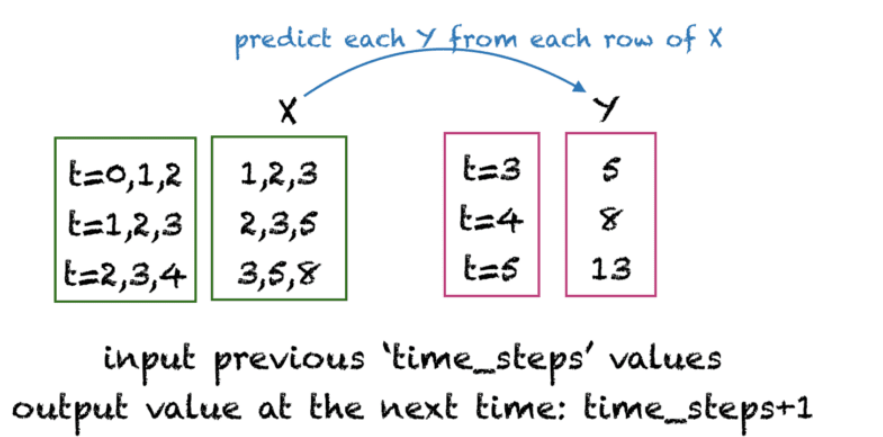

In [11]:
def get_fib_XY(total_fib_numbers, time_steps, train_percent, scale_data=True):
    dat, scaler = get_fib_seq(total_fib_numbers, scale_data)     # Loading the dataset.

    #
    # Your code to create training and test dataset.

    # Note - function argument total_fib_number is the total number of Fibonacci numbers,
    # time_step is the length of the input,
    # and train_percent determines the ratio of train and test size

    Y_ind = np.arange(time_steps, len(dat), 1)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[0:rows_x]
    for i in range(time_steps-1):
        temp = dat[i+1:rows_x+i+1]
        X = np.column_stack((X, temp))
    # random permutation with fixed seed
    rand = np.random.RandomState(seed=13)
    idx = rand.permutation(rows_x)
    split = int(train_percent*rows_x)
    train_ind = idx[0:split]
    test_ind = idx[split:]
    trainX = X[train_ind]
    trainY = Y[train_ind]
    testX = X[test_ind]
    testY = Y[test_ind]
    trainX = np.reshape(trainX, (len(trainX), time_steps, 1))
    testX = np.reshape(testX, (len(testX), time_steps, 1))

    return trainX, trainY, testX, testY, scaler



In [12]:
# Check if the function works correctly

get_fib_XY(8, 3, 0.8)

(array([[[0.03030303],
         [0.06060606],
         [0.12121212]],
 
        [[0.12121212],
         [0.21212121],
         [0.36363636]],
 
        [[0.21212121],
         [0.36363636],
         [0.60606061]],
 
        [[0.        ],
         [0.03030303],
         [0.06060606]]]),
 array([0.21212121, 0.60606061, 1.        , 0.12121212]),
 array([[[0.06060606],
         [0.12121212],
         [0.21212121]]]),
 array([0.36363636]),
 MinMaxScaler())

In [13]:
def get_fib_XY_check(total_fib_numbers, time_steps, train_percent, scale_data=True):
    dat, scaler = get_fib_seq(total_fib_numbers, scale_data)      # Loading the dataset.

    # Your code to create training and test dataset.

    # Note - function argument total_fib_number is the total number of Fibonacci numbers,
    # time_step is the length of the input,
    # and train_percent determines the ratio of train and test size

    Y_ind = np.arange(time_steps, len(dat), 1) # create the index array
    print('len(dat)=',len(dat))
    print('Y_ind=',Y_ind, '\n')

    Y = dat[Y_ind]   # create normalised Fibonacci sequence
    print('Y=',Y)

    rows_x = len(Y)           # numder of rows
    print('len(Y)=',len(Y))
    print('rows_x=',rows_x)

    X = dat[0:rows_x]     # first column of the Fibonacci sequence array
    print('X=',X, '\n')

    # create inputs array by adding others colomns
    for i in range(time_steps-1):
        temp = dat[i+1:rows_x+i+1]

        # np.column_stac -- Stack 1-D arrays as columns into a 2-D array.
        X = np.column_stack((X, temp))

    print('X:','\n',X)
    print('temp=',temp, '\n')

    # random permutation with fixed seed
    rand = np.random.RandomState(seed=13)
    print('rand=',rand)

    # permutation() -- Randomly permute a sequence or return a permuted range.

    # permute(mix) the indexes
    idx = rand.permutation(rows_x)
    print('idx=',idx, '\n')

    # number of train rows
    split = int(train_percent*rows_x)
    print('split=',split, '\n')

    # indexes of the train array
    train_ind = idx[0:split]
    print('train_ind=',train_ind)
    print('train_ind.shape=',train_ind.shape)

    # indexes of the test array
    test_ind = idx[split:]
    print('test_ind=',test_ind)
    print('test_ind.shape=',test_ind.shape, '\n')

    # create mixed train inputs
    trainX = X[train_ind]
    print('trainX:','\n',trainX)
    print('trainX.shape=',trainX.shape)

    # create mixed train outputs
    trainY = Y[train_ind]
    print('trainY',trainY)
    print('trainY.shape=',trainY.shape, '\n')

    # create mixed test inputs
    testX = X[test_ind]
    print('testX:','\n',testX)
    print('testX.shape=',testX.shape)

    # create mixed test outputs
    testY = Y[test_ind]
    print('testY=',testY)
    print('testY.shape=',testY.shape, '\n')

    # reshape train and test inputs (add one more dimension; it's necessary for keras)

    trainX = np.reshape(trainX, (len(trainX), time_steps, 1))
    print('trainX:','\n',trainX)
    print('trainX.shape=',trainX.shape, '\n')

    testX = np.reshape(testX, (len(testX), time_steps, 1))
    print('testX=',testX)
    print('testX.shape=',testX.shape)


    return trainX, trainY, testX, testY, scaler



In [14]:
get_fib_XY_check(8, 3, 0.8)

len(dat)= 8
Y_ind= [3 4 5 6 7] 

Y= [0.12121212 0.21212121 0.36363636 0.60606061 1.        ]
len(Y)= 5
rows_x= 5
X= [0.         0.03030303 0.06060606 0.12121212 0.21212121] 

X: 
 [[0.         0.03030303 0.06060606]
 [0.03030303 0.06060606 0.12121212]
 [0.06060606 0.12121212 0.21212121]
 [0.12121212 0.21212121 0.36363636]
 [0.21212121 0.36363636 0.60606061]]
temp= [0.06060606 0.12121212 0.21212121 0.36363636 0.60606061] 

rand= RandomState(MT19937)
idx= [1 3 4 0 2] 

split= 4 

train_ind= [1 3 4 0]
train_ind.shape= (4,)
test_ind= [2]
test_ind.shape= (1,) 

trainX: 
 [[0.03030303 0.06060606 0.12121212]
 [0.12121212 0.21212121 0.36363636]
 [0.21212121 0.36363636 0.60606061]
 [0.         0.03030303 0.06060606]]
trainX.shape= (4, 3)
trainY [0.21212121 0.60606061 1.         0.12121212]
trainY.shape= (4,) 

testX: 
 [[0.06060606 0.12121212 0.21212121]]
testX.shape= (1, 3)
testY= [0.36363636]
testY.shape= (1,) 

trainX: 
 [[[0.03030303]
  [0.06060606]
  [0.12121212]]

 [[0.12121212]
  [0.2121

(array([[[0.03030303],
         [0.06060606],
         [0.12121212]],
 
        [[0.12121212],
         [0.21212121],
         [0.36363636]],
 
        [[0.21212121],
         [0.36363636],
         [0.60606061]],
 
        [[0.        ],
         [0.03030303],
         [0.06060606]]]),
 array([0.21212121, 0.60606061, 1.        , 0.12121212]),
 array([[[0.06060606],
         [0.12121212],
         [0.21212121]]]),
 array([0.36363636]),
 MinMaxScaler())

In [15]:
#np.column_stack?

In [16]:
#np.random.RandomState.permutation?

### In the following code, we test the performance with the help of a simple RNN.


#### Set up parameters

In [25]:
time_steps = 20
hidden_units = 4
epochs = 53

#### Create a traditional RNN network

In [ ]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mse', optimizer='adam')
    return model
model = Sequential()
model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(units=dense_units, activation=activation[1]))
model.compile(loss='mse', optimizer='adam')

In [21]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mse', optimizer='adam')
    return model

In [22]:
model_RNN = create_RNN(hidden_units=hidden_units, dense_units=1, input_shape=(time_steps,1),
                   activation=['tanh', 'tanh'])

![image.png](attachment:87ecc6c6-cdc0-4f5f-9fbf-9d5f1d482525.png)

##### tf.keras.activations.tanh

https://www.tensorflow.org/api_docs/python/tf/keras/activations/tanh

In [26]:
model_RNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 2)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,273 (44.04 KB)

 Trainable params: 11,273 (44.04 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Your code to get  dataset for the network - trainX, trainY, testX, testY,
# using function get_fib_XY(1200, time_steps, 0.7)

trainX, trainY, testX, testY, scaler  = get_fib_XY(1200, time_steps, 0.7)

#### Train the network

In [27]:
history = model_RNN.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=1)

Epoch 1/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 3.8325e-04
Epoch 2/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.1827e-04
Epoch 3/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.7201e-04
Epoch 4/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.1455e-04
Epoch 5/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.4313e-04
Epoch 6/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.8659e-05
Epoch 7/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.5441e-05
Epoch 8/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 6.8955e-04
Epoch 9/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.8752e-05
Epoch 10/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.5520e-04
Epoch 11/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4.9500e-05
Epoch 12/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.6577e-06
Epoch 13/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1452e-04
Epoch 14/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.6003e-04
E

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

<ipython-input-30-0c4a33308058>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(Epochs, losses, 'bo', label='Training loss', color='m')


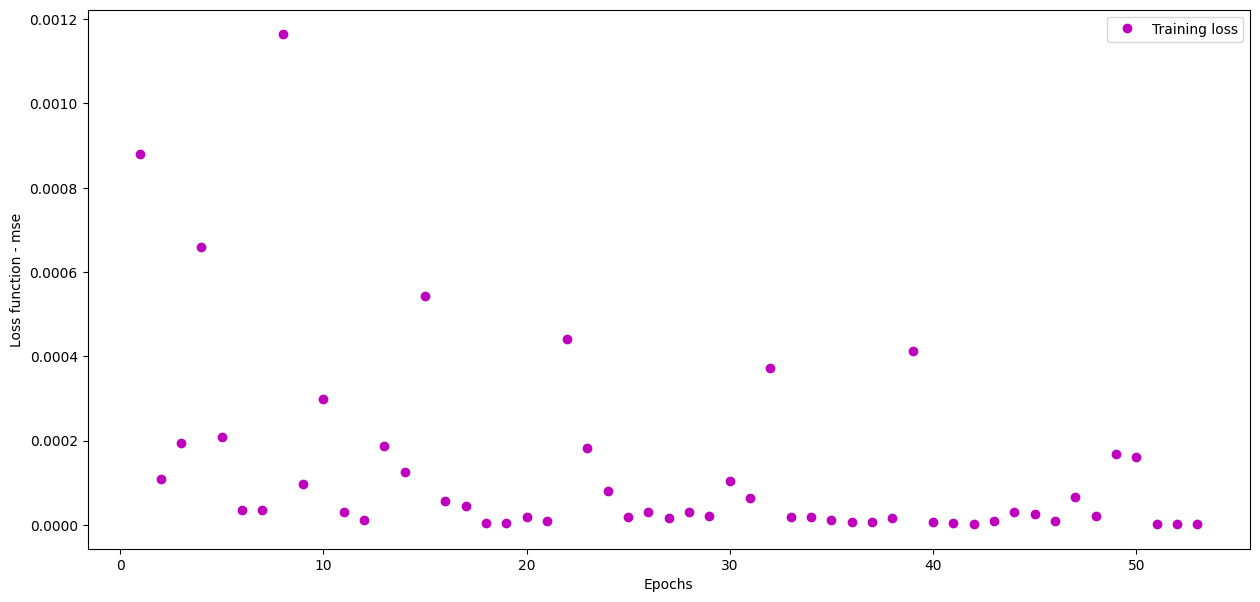

In [30]:
history_dict = history.history

losses = history_dict['loss']
Epochs = range(1, len(losses) + 1)

plt.figure(num=1, figsize=(15,7))
plt.plot(Epochs, losses, 'bo', label='Training loss', color='m')

plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()

#### Evalute model

In [31]:
train_mse = model_RNN.evaluate(trainX, trainY)
test_mse = model_RNN.evaluate(testX, testY)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1854e-05
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3439e-04 


#### Print train and test error metrics

In [32]:
print("Train set MSE = ", train_mse)
print("Test set MSE = ", test_mse)

Train set MSE =  1.152517506852746e-05
Test set MSE =  0.00029993694624863565


### The following code creates an attention layer. You need to understand each line to know how an attention layer can be created.


In [33]:
# Add attention layer to the deep learning network

# decorator is essential for proper serialisation
@tf.keras.utils.register_keras_serializable()

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = tf.tanh(tf.matmul(x,self.W)+self.b)

        # Remove dimension of size 1
        e = tf.squeeze(e, axis=-1)

        # Compute the weights
        alpha = tf.nn.softmax(e)

        # Reshape to tensorFlow format
        alpha = tf.expand_dims(alpha, axis=-1)

        # Compute the context vector
        context = x * alpha
        context = tf.reduce_sum(context, axis=1)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

### The following code develops an RNN with an attention layer to predict the Fibonacci sequence.



In [34]:
def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x=Input(shape=input_shape)
    RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)

    attention_layer = attention()(RNN_layer)      # Note = Attention layer is added here.

    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model=Model(x,outputs)
    model.compile(loss='mse', optimizer='adam')
    return model


In [35]:
# Create the model with attention. Use activation function 'tanh'

model_attention = create_RNN_with_attention(hidden_units=hidden_units, dense_units=1,
                                  input_shape=(time_steps,1), activation='tanh')

In [36]:
# Your code to print the model summary

model_attention.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 20, 4)          │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (attention)           │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53 (212.00 B)

 Trainable params: 53 (212.00 B)

 Non-trainable params: 0 (0.00 B)

In [37]:
history_2 = model_attention.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=1)

Epoch 1/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0017
Epoch 2/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0018
Epoch 3/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.3921e-04
Epoch 4/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.2664e-04
Epoch 5/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.9088e-04
Epoch 6/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.4056e-04
Epoch 7/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 8.5478e-04
Epoch 8/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.6484e-04
Epoch 9/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0016
Epoch 10/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0015
Epoch 11/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0011
Epoch 12/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.3436e-04
Epoch 13/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.7201e-04
Epoch 14/53
826/826 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.5868e-04
Epoch 15/53
826/826 ━

#### Hint:

You can copy blocks of code in the cells above and cells from previous weeks of practice sessions.

Some are easy enough to copy, some need to be slightly modified. This can speed up your code creation.


<ipython-input-38-480ddf358b03>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(Epochs, losses, 'r+', label='Training loss', color='g')


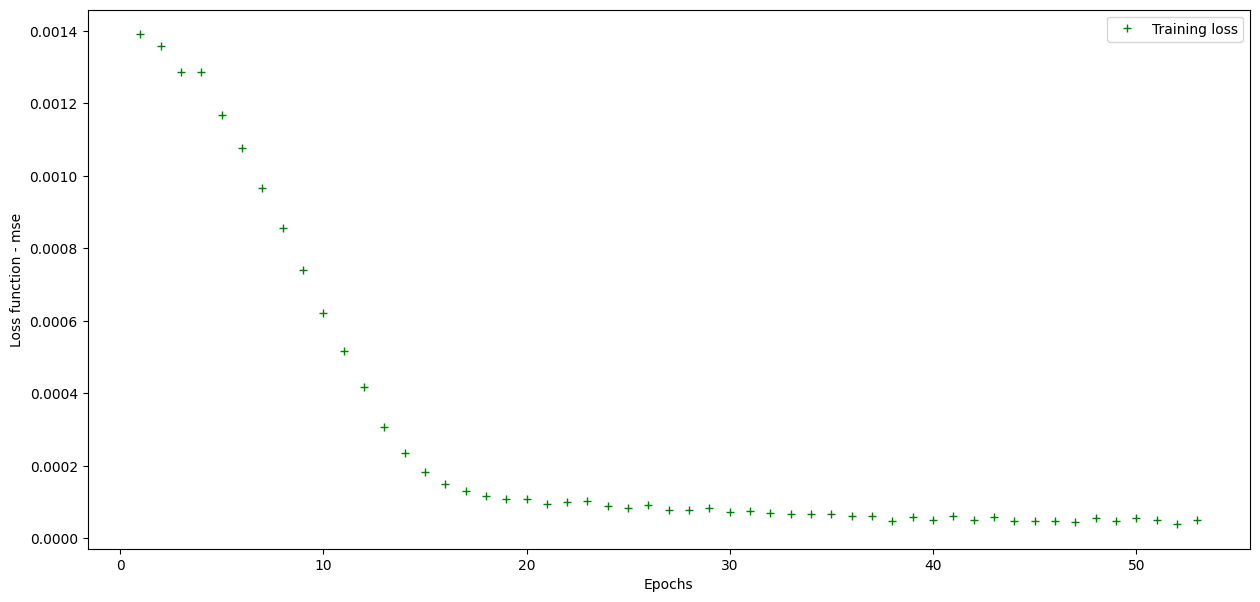

In [38]:
history_dict = history_2.history

losses = history_dict['loss']
Epochs = range(1, len(losses) + 1)

plt.figure(num=1, figsize=(15,7))
plt.plot(Epochs, losses, 'r+', label='Training loss', color='g')

plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()

In [39]:
train_mse_attn = model_attention.evaluate(trainX, trainY)
test_mse_attn = model_attention.evaluate(testX, testY)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8259e-05
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2897e-05 


In [40]:
print("Train set MSE with attention = ", train_mse_attn)
print("Test set MSE with attention = ", test_mse_attn)

Train set MSE with attention =  2.7996449716738425e-05
Test set MSE with attention =  2.012360710068606e-05


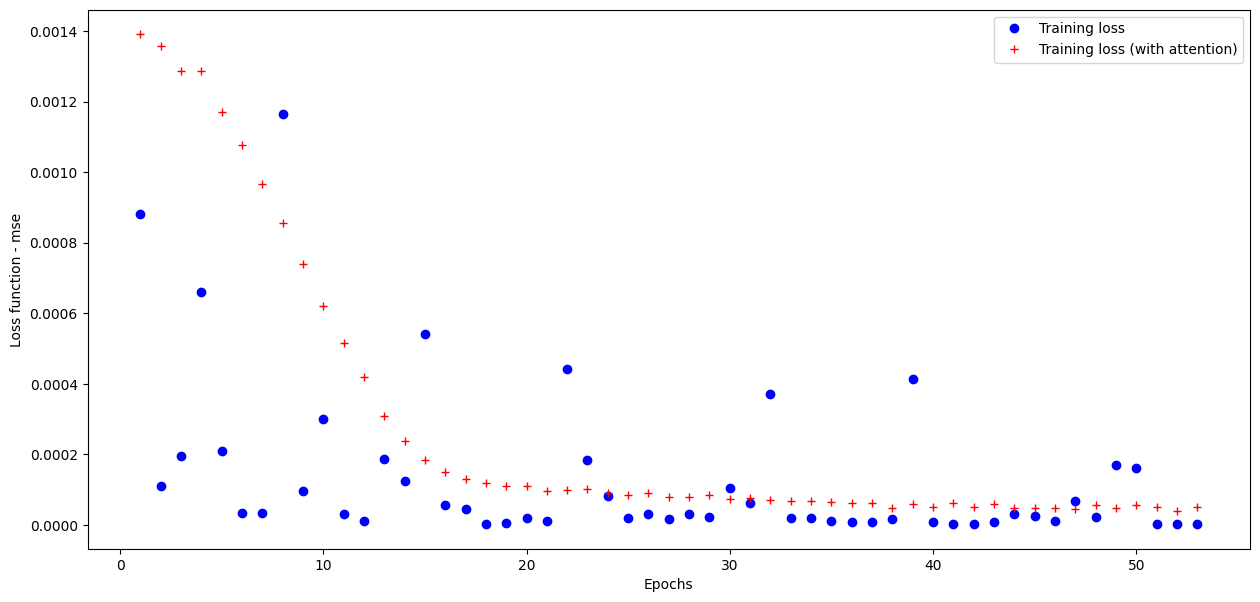

In [41]:
history_dict_1 = history.history
history_dict_2 = history_2.history

losses_1 = history_dict_1['loss']
losses_2 = history_dict_2['loss']

Epochs_1 = range(1, len(losses_1) + 1)
Epochs_2 = range(1, len(losses_2) + 1)
plt.figure(num=1, figsize=(15,7))

plt.plot(Epochs_1, losses_1, 'bo', label='Training loss')
plt.plot(Epochs_2, losses_2, 'r+', label='Training loss (with attention)')

plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()



### Plot the train and test MSE performance for the 'Simple RNN' and 'RNN with an attention layer'.


In [42]:
import pandas as pd

In [43]:
# Copy here YOUR results received for Train and Test MSE:

ErrorMetrics =  [ [4.628741226042621e-05, 2.7580872483667918e-05],
                  [3.645733158919029e-05, 2.13204857573146e-05]
                ]
ErrorMetrics



[[4.628741226042621e-05, 2.7580872483667918e-05],
 [3.645733158919029e-05, 2.13204857573146e-05]]

In [44]:
ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = ['Train','Test']
ErrorMetrics_pd.index = ['Simple RNN','RNN with an attention layer']
ErrorMetrics_pd

,Train,Test
Simple RNN,0.000046,0.000028
RNN with an attention layer,0.000036,0.000021


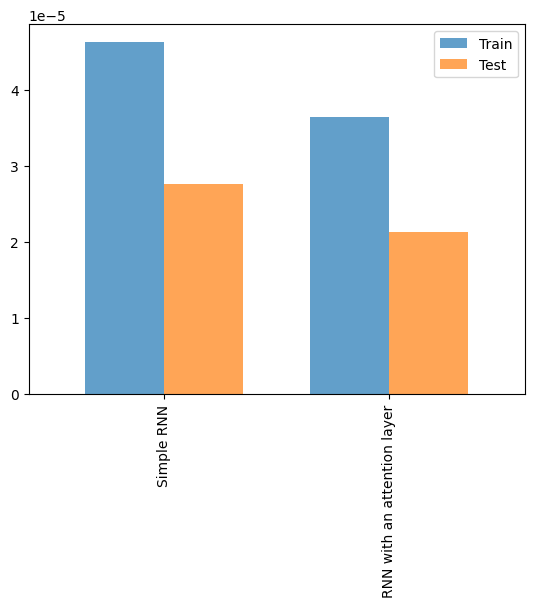

In [46]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)
plt.show()

# Lab Logbook Requirement:

<html> <h3 style="; color:blue;">

1) Modify the training parameter of the RNN with an attention layer model using the following formulas:

Modify the number of epochs:
Z + 50
, where your SID is: XXXXXXZ

Use EarlyStopping() and ModelCheckpoint() function to save the best modetl in the file 'best_attention_model.keras'
Modify the patience parameter:
Z + 10
, where your SID is: XXXXXXZ

2) Modify time_steps = 20 and hidden_units = 4
3) Leave other parameters the same as in the practical session
4) Calculate and demonstrate the received loss for train and test datasets
5) Plot the Loss function (MSE) graph during the training process for the 3 models together
6) Please only add to your Lab Logbook print-screens of:
- calculation of your parameters
- code your Use EarlyStopping() and ModelCheckpoint() functions
- code and training result using model.fit()
- received loss for train and test datasets
- Loss (MSE) graph for the 3 models together during the training process
- performance histogram for train and test loss (MSE) of the 3 models together


</h3> </html>


<html> <h3 style="color:red;">
NOTE: DON'T FORGET TO SAVE AND BACK UP YOUR COMPLETED JUPYTER NOTEBOOK AND LAB LOGBOOK ON GITHUB OR ONEDRIVE.
</h3> </html>

### Test the above model with different parameters, layer size, train and test ratio, and time steps.



In [47]:
# Early Stopping libraries

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [49]:
# Load the model with the custom_objects parameter

Best_attention_model = keras.models.load_model(
    'best_attention_model.keras',
    custom_objects={'attention': attention}
    )

In [50]:
time_steps = 20
hidden_units = 4
epochs = 53
patience=20

In [51]:
model_attention_2 = create_RNN_with_attention(hidden_units=hidden_units, dense_units=1,
                                  input_shape=(time_steps,1), activation='tanh')

In [52]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=patience, verbose=1)

In [53]:
mc = ModelCheckpoint('best_attention_model.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [54]:
model_attention_2.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 20, 4)          │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (attention)         │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53 (212.00 B)

 Trainable params: 53 (212.00 B)

 Non-trainable params: 0 (0.00 B)

In [55]:
history_3 = model_attention_2.fit(trainX, trainY,
                                  epochs=epochs, batch_size=1,
                                  validation_split=0.2,
                                  callbacks=[es, mc], verbose=1)

Epoch 1/53
650/660 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051
Epoch 1: val_loss improved from inf to 0.00000, saving model to best_attention_model.keras
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0050 - val_loss: 3.0871e-10
Epoch 2/53
649/660 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040
Epoch 2: val_loss improved from 0.00000 to 0.00000, saving model to best_attention_model.keras
660/660 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0040 - val_loss: 1.6174e-10
Epoch 3/53
660/660 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8027e-04
Epoch 3: val_loss did not improve from 0.00000
660/660 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7.8142e-04 - val_loss: 3.0040e-08
Epoch 4/53
655/660 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 4: val_loss did not improve from 0.00000
660/660 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0017 - val_loss: 7.5469e-07
Epoch 5/53
660/660 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 5: val_loss did not improve from 0.00000
660/660 ━━━━━━

<ipython-input-59-c90d922b1855>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(Epochs_1, losses_1, 'bo', label='Training loss', color='brown')
<ipython-input-59-c90d922b1855>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(Epochs_2, losses_2, 'r+', label='Training loss (with attention)', color='b')


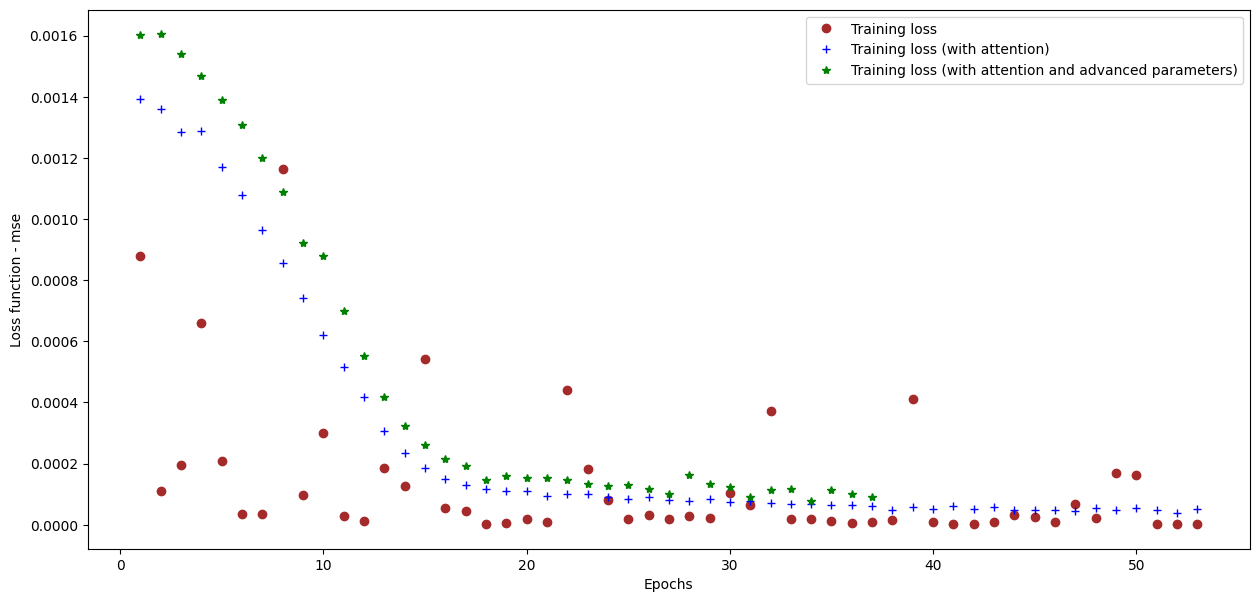

In [59]:
history_dict_1 = history.history
history_dict_2 = history_2.history
history_dict_3 = history_3.history

losses_1 = history_dict_1['loss']
losses_2 = history_dict_2['loss']
losses_3 = history_dict_3['loss']

Epochs_1 = range(1, len(losses_1) + 1)
Epochs_2 = range(1, len(losses_2) + 1)
Epochs_3 = range(1, len(losses_3) + 1)
plt.figure(num=1, figsize=(15,7))

plt.plot(Epochs_1, losses_1, 'bo', label='Training loss', color='brown')
plt.plot(Epochs_2, losses_2, 'r+', label='Training loss (with attention)', color='b')
plt.plot(Epochs_3, losses_3, 'g*', label='Training loss (with attention and advanced parameters)')


plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()


<ipython-input-60-9bea1b7ad0e1>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(Epochs_1, losses_1, 'bo', label='Training loss', color='brown')
<ipython-input-60-9bea1b7ad0e1>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(Epochs_2, losses_2, 'r+', label='Training loss (with attention)', color='b')


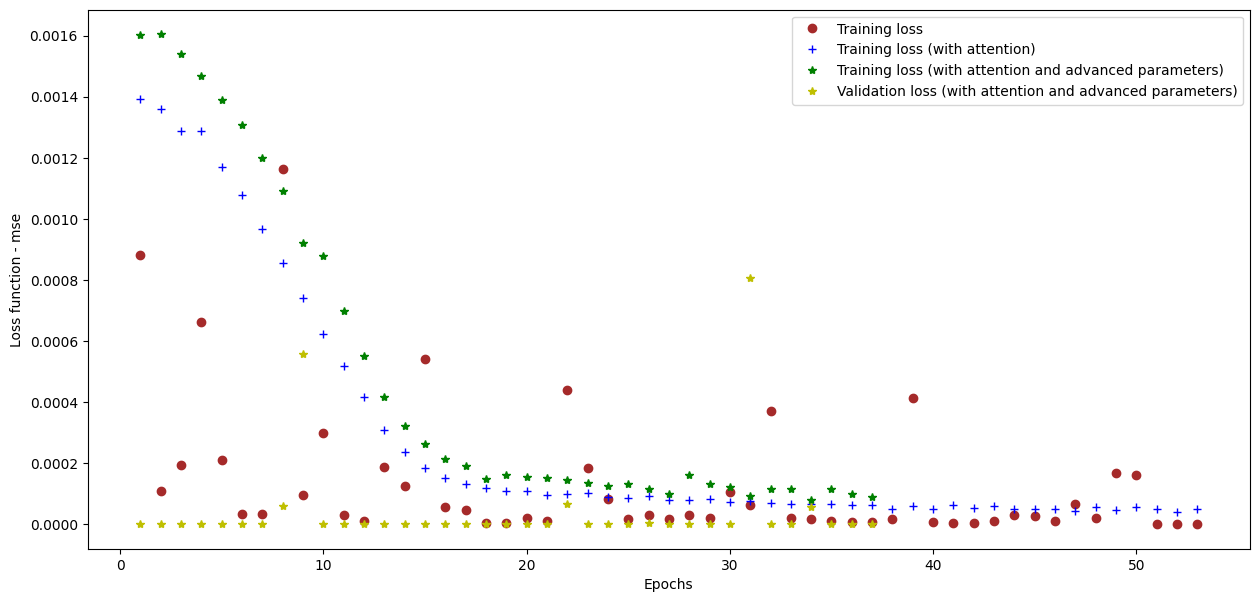

In [60]:
history_dict_1 = history.history
history_dict_2 = history_2.history
history_dict_3 = history_3.history

losses_1 = history_dict_1['loss']
losses_2 = history_dict_2['loss']
losses_3 = history_dict_3['loss']
losses_4 = history_dict_3['val_loss']

Epochs_1 = range(1, len(losses_1) + 1)
Epochs_2 = range(1, len(losses_2) + 1)
Epochs_3 = range(1, len(losses_3) + 1)
plt.figure(num=1, figsize=(15,7))

plt.plot(Epochs_1, losses_1, 'bo', label='Training loss', color='brown')
plt.plot(Epochs_2, losses_2, 'r+', label='Training loss (with attention)', color='b')
plt.plot(Epochs_3, losses_3, 'g*', label='Training loss (with attention and advanced parameters)')
plt.plot(Epochs_3, losses_4, 'y*', label='Validation loss (with attention and advanced parameters)')


plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()


In [62]:
# Upload the saved best model

Best_attention_model.keras = keras.models.load_model('best_attention_model.keras')

In [68]:
train_mse_attn = model_attention.evaluate(trainX, trainY)
test_mse_attn = model_attention.evaluate(testX, testY)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8259e-05
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2897e-05 


In [69]:
print("Train set MSE with attention = ", train_mse_attn)
print("Test set MSE with attention = ", test_mse_attn)

Train set MSE with attention =  2.7996449716738425e-05
Test set MSE with attention =  2.012360710068606e-05


In [70]:
ErrorMetrics =  [ [4.628741226042621e-05, 2.7580872483667918e-05],
                  [3.645733158919029e-05, 2.13204857573146e-05],
                  [2.7996449716738425e-05, 2.012360710068606e-05]
                ]
ErrorMetrics


[[4.628741226042621e-05, 2.7580872483667918e-05],
 [3.645733158919029e-05, 2.13204857573146e-05],
 [2.7996449716738425e-05, 2.012360710068606e-05]]

In [71]:
ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = ['Train','Test']
ErrorMetrics_pd.index = ['Simple RNN', 'RNN with an attention layer', 'RNN with attention and advanced parameters']
ErrorMetrics_pd

,Train,Test
Simple RNN,0.000046,0.000028
RNN with an attention layer,0.000036,0.000021
RNN with attention and advanced parameters,0.000028,0.000020


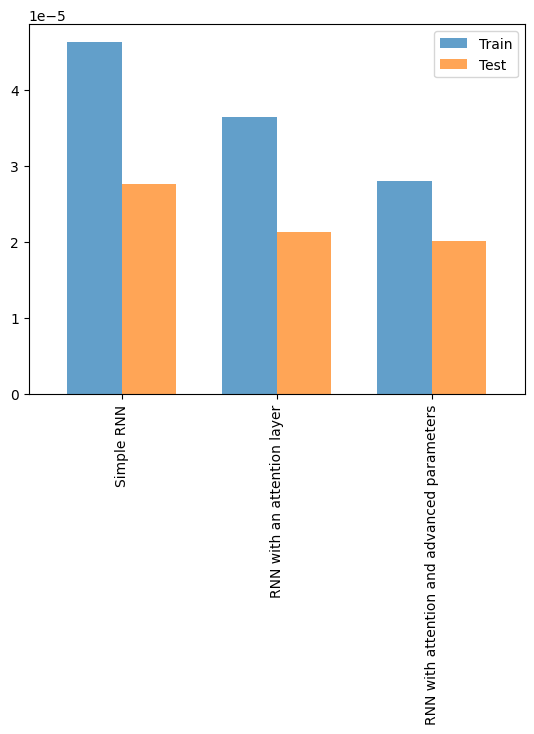

In [72]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)
plt.show()